In [13]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import lines
import matplotlib.cm as cm
import tqdm
from tqdm.notebook import tqdm as tqdm
import multiprocessing as mproc
import os
import random

import model_opt
import data_generate
import algo_GD

_cmap = plt.cm.jet
w_init = 3
_t_max = 4000
f = model_opt.RosenBrock(err = 100)

In [14]:
def SGD_update(w):
    f = model_opt.RosenBrock(err = 100)
    algo = algo_GD.SGD(w_init=w,t_max=_t_max,a=0.0005)
    for i in algo:
        algo.update(model=f)
    return algo.wstore
    

In [15]:
if __name__ == "__main__":
    
    # 自分のマシンでコアが４つ
    cpu_count = mproc.cpu_count()
    
    # 同じ初期値でスタート
    w = np.full((cpu_count, 2), w_init)

    mypool = mproc.Pool(cpu_count)
    
    # ステップ数半分のところでwを全てのコアの平均に更新
    # 最終１０ステップをコアの候補とし全コアの平均を最終結果とする
    first_result = np.array(mypool.map(func=SGD_update, iterable=w))
    w = np.mean(first_result[:,-1],axis=0)
    w = np.full((cpu_count, 2), w)
    second_result = np.array(mypool.map(func=SGD_update, iterable=w))
    process_result = np.mean(second_result[:,-10:],axis=1)
    last_result = np.mean(process_result,axis=0)

    # Memory management.
    mypool.close() # important for stopping memory leaks.
    mypool.join() # wait for all workers to exit.

<Figure size 864x864 with 0 Axes>

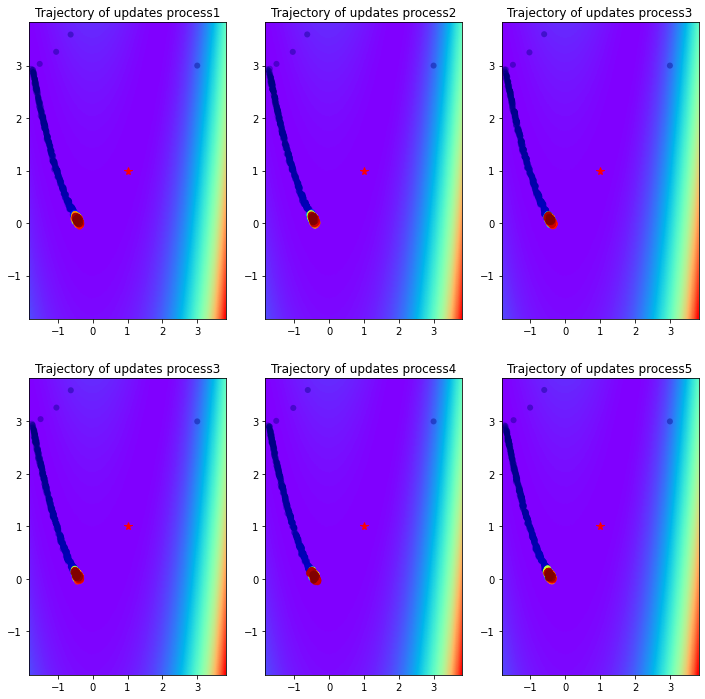

In [16]:
# 目的関数の真の値
w_star = f.w_star
w_store = np.concatenate([first_result,second_result],axis=1)
shape = w_store.shape
k = np.reshape(w_store,(2,-1,shape[1],shape[2]))



# wの軌跡
tmpdel = np.linalg.norm(w_star-w_store[0][0])
xvals = np.arange(w_star[0]-tmpdel, w_star[0]+tmpdel, 0.01)
yvals = np.arange(w_star[1]-tmpdel, w_star[1]+tmpdel, 0.01)
X, Y = np.meshgrid(xvals, yvals)
Z = f.f_opt([X,Y])
myfig = plt.figure(figsize=(12,12))


fig, axes = plt.subplots(k.shape[0],k.shape[1] , figsize=(12,12))
for i,value1 in enumerate(k):
    for j,value2 in enumerate(value1):
        axes[i][j].set_title("Trajectory of updates process{}".format(2*i + j + 1))
        axes[i][j].pcolor(X, Y, Z,cmap=plt.cm.rainbow)


        c = np.linspace(0, _t_max * 2, len(w_store[0]))
        axes[i][j].scatter(value2.T[0],value2.T[1],c=c,cmap = _cmap,linewidths=0.01,alpha=0.4)
        axes[i][j].plot(*w_star, 'r*', markersize=8)


In [ ]:
color = ['k*', 'b*', 'g*', 'c*']

tmpdel = np.linalg.norm(max(abs(process_result.max()-w_star[0]),abs(process_result.min()-w_star[0])))
xvals = np.arange(w_star[0]-tmpdel, w_star[0]+tmpdel, 0.001)
yvals = np.arange(w_star[1]-tmpdel, w_star[1]+tmpdel, 0.001)
x1, x2 = np.meshgrid(xvals, yvals)
Z = circle(x1, x2,w_star[0])

myfig = plt.figure(figsize=(12,12))
ax1 = myfig.add_subplot(2,2,1)
CS = ax1.contour(x1, x2, Z, levels=15)
ax1.plot(*w_star, 'r*', markersize=8,label="w_star")
for i,value in enumerate(process_result):
    ax1.plot(*value, color[i], markersize=8,label="process {}".format(i+1))
ax1.plot(*last_result, 'y*', markersize=8,label="last result")

ax1.legend()

In [ ]:
fig, axes = plt.subplots(k.shape[0],k.shape[1] , figsize=(12,12))
for i,value1 in enumerate(k):
    for j,value2 in enumerate(value1):
        print(f.f_opt(value2))
        axes[i][j].set_title("loss transition process{}".format(2*i + j + 1))        
        axes[i][j].set_xlabel('number of update steps')
        axes[i][j].set_ylabel('f')
        axes[i][j].plot(list(range(value2.shape[0])),f.f_opt(value2))


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

x = np.arange(-2,2, 0.01)
y = np.arange(-2, 2, 0.01)
X, Y = np.meshgrid(x, y)
Z = f.f_opt([X,Y])
plt.pcolor(X, Y, Z, cmap=plt.cm.rainbow)
plt.colorbar()
plt.show()

In [ ]:
Z.shape